In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from tqdm import tqdm, trange, tqdm_notebook

from matplotlib.pylab import get_cmap
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as sp
import sys, os
import cPickle as pickle
from glob import glob

fs=20
fs_ticks = 16
sys.path.append('/Users/mhuber/PointSource/skylab/')
from SkyMap import SkyMap

from scipy.stats import norm

# define sfb colors
colors = ['#3850A1', '#F79645', '#993A91']
#new trial
colors = ['#0D589A', '#5DB5D0', '#A9DBB7','blue']

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp

from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D


from scipy.interpolate import splrep, splev
from copy import deepcopy 

In [2]:
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from PyAstronomy import pyasl

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [4]:
from tools import *
from tools import _trans

# Calculate the expected mean number of signal (and background) events for different energy thresholds

use some standard candle source flux for this, e.g. the txs

<IPython.core.display.Javascript object>


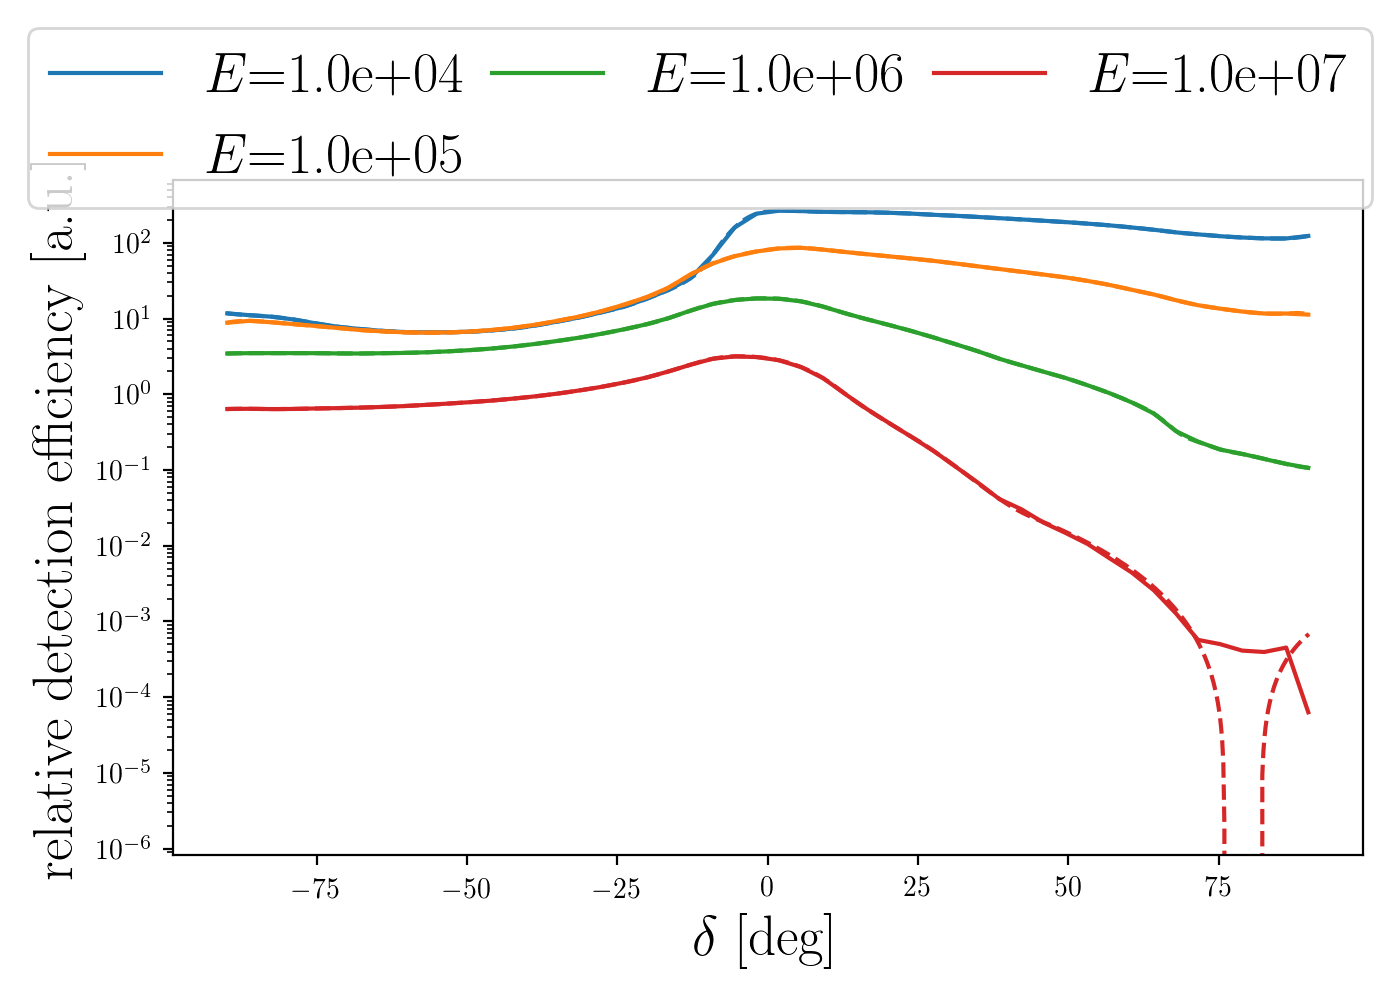

31536000.0


In [5]:
path = "/Users/mhuber/StackingSkylab/MultiYearPointSourceData/"
mc = np.load(os.path.join(path,'IC86-2012_MC.npy'))

ang=4
decs = np.linspace(-np.pi/2+np.radians(0.1), np.pi/2-np.radians(0.1), 50)
xvals = np.linspace(-np.pi/2, np.pi/2, 1000)

fig,ax=plt.subplots(figsize=(7,5))
tcks = dict()
gamma = 2.

txs_time = 60*60*24. *365
print(txs_time)
txs_phi = 1e-9 # GeV / cm2 / s


# get the phi_min, phi_max from the new diffuse analysis
gamma = 2.28
txs_phi = 1.44e-18 *4*np.pi*10**(5*gamma)

E_thres = [1e4, 1e5, 1e6, 1e7]
for Ethi in E_thres:
    
    Res = np.zeros_like(decs)
    for i, deci in enumerate(decs):
    
        if deci > np.radians(30): ang=10
        dec_min, dec_max = np.sin(deci-np.radians(ang)), np.sin(deci+np.radians(ang))
        Omega = 2 * np.pi * (dec_max - dec_min)
        dec_mask = (np.sin(mc['trueDec']) > dec_min)&(np.sin(mc['trueDec']) < dec_max)

        maskE = mc['trueE'] > Ethi 
        DetEff = np.sum(mc['ow'][dec_mask&maskE] * mc['trueE'][dec_mask&maskE]**(-gamma)) / Omega 
        
        


        
        Res[i] = DetEff *txs_time * txs_phi
    
    Res_max = np.max(Res)
    tcki = splrep(decs, Res, s=1.e-4)
    spl_val = splev(xvals, tcki)
    
    tcks[Ethi] = tcki
    p=ax.plot(np.degrees(decs), Res, label=r'$E$={0:.1e}'.format(Ethi))
    ax.plot(np.degrees(xvals), spl_val, ls='dashed', color=p[0].get_color())
    
fig.legend(loc='upper center', mode='expand', fontsize=fs, ncol=3)
ax.set_xlabel(r'$\delta$ [deg]',fontsize=fs)
ax.set_ylabel(r'relative detection efficiency [a.u.]',fontsize=fs)
ax.set_yscale('log')
fig.tight_layout()

plt.subplots_adjust(top = 0.82)
plt.show()

# this step gets you the number of events in plenum

In [7]:
NSIDE = 2**6
npix = hp.nside2npix(NSIDE)

ngrid=500

In [9]:
fact = 1.
poles = {'IceCube':(np.radians(0), np.radians(-90.)),
         'Gen2':(np.radians(0), np.radians(-90.)),
         'P-ONE':(-np.radians(123.3656), np.radians(48.4284)),
         'KM3NeT':(np.radians(16.1), np.radians(36.27)) ,
         'Baikal-GVD':(np.radians(108.1650), np.radians(53.5587)),
         #'X, China':(np.radians(111.918), np.radians(8.640)),
         #'SA, Cape Town ':(np.radians(18.4241), np.radians(-33.9249)),
        #'hypothetical':(np.radians(0.2093), np.radians(-0.8688)),
        }
      
comb_values_Eth = dict()


for Ethi in E_thres:
    comb_values_i = dict()
    for i,(name, new_pole) in enumerate(sorted(poles.iteritems())):    

        vals = np.zeros(npix)    
        rot_angles = np.arange(0.,360., 30.) #15.
        for rot_ra in tqdm(rot_angles):
            vals2 = np.zeros(npix)
            new_ra = new_pole[0] + np.radians(rot_ra)

            x = np.linspace(0,2*np.pi, 1.e3)
            y = np.linspace(-np.pi/2,np.pi/2 ,500)

            xx, yy = np.meshgrid(x,y,indexing='ij')

            ra2 , dec2 = rotate(0, -np.pi/2, new_ra, new_pole[1],xx.ravel(),yy.ravel())


            lat2 = np.pi/2 + dec2
            lat2 = lat2
            lon2, lat2 = _trans(ra2, lat2)

            p = hp.ang2pix(NSIDE, lat2, lon2)

            tcki = tcks[Ethi]
            if name == 'IceCube' or 'Gen2' in name:
                vals2[p] = splev(yy.ravel(), tcki)
            else:
                vals2[p] = splev(yy.ravel(), tcki) 

            if name == 'Gen2':
                vals2 *= 7.5

            vals = vals + vals2 * (1. / len(rot_angles))

        comb_values_i[name] = vals
        
    comb_values_Eth[Ethi] = comb_values_i
blub = 5000

100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


# extract the plenum numbers

In [ ]:
fig =  plt.figure(figsize=(16,10))


n2ind = {0:221, 1:222, 2:223, 3:224}

av_values = deepcopy(comb_values_Eth)

caxs = dict()
for i, (ethi, vals) in enumerate(av_values.iteritems()):
    
    ax = fig.add_subplot(n2ind[i], projection='hammer',
                                       rasterized=True)

    vals_tot = np.zeros(npix)
    for (name, vali) in vals.iteritems():
        if 'Gen2' in name:
            continue
        vals_tot += vali
    cax=plot_area(vals_tot, ax, npix=ngrid,  alpha=1., #vmin=0., vmax=1.,
             shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

    caxs[ethi] = cax
    #-------------------------------
    # fix the labels
    #-------------------------------

    set_ticks(ax, fs=fs)
    

    #---------------------------------------
    # add the galactic center and plane
    #---------------------------------------

    if i==0:
        add_plane(ax, color='black')
    else:
        add_plane(ax, color='black', label='__None__')

    #---------------------------------------
    #  add also TXS
    #---------------------------------------
    if i==0:
        add_txs(ax, marker='o' ,c='#DC6C25')
    else:
        add_txs(ax, marker='o' ,c='#DC6C25', label='__None__')
  

    ax.text(0.73,0.97, ethi, fontsize=30 ,
                 transform = ax.transAxes)

    

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')

fig.tight_layout()
plt.subplots_adjust(top = 0.9, right=0.9, wspace=0.15)

# extract the icecube numbers 

In [ ]:
fig =  plt.figure(figsize=(16,10))


n2ind = {0:221, 1:222, 2:223, 3:224}

av_values = deepcopy(comb_values_Eth)

caxs_icecube = dict()
for i, (ethi, vals) in enumerate(av_values.iteritems()):
    
    ax = fig.add_subplot(n2ind[i], projection='hammer',
                                       rasterized=True)

    vals_tot = np.zeros(npix)
    for (name, vali) in vals.iteritems():
        if name != 'IceCube':
            continue
        vals_tot += vali
    cax=plot_area(vals_tot, ax, npix=ngrid,  alpha=1., #vmin=0., vmax=1.,
             shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

    caxs_icecube[ethi] = cax
    #-------------------------------
    # fix the labels
    #-------------------------------

    set_ticks(ax, fs=fs)
    

    #---------------------------------------
    # add the galactic center and plane
    #---------------------------------------

    if i==0:
        add_plane(ax, color='black')
    else:
        add_plane(ax, color='black', label='__None__')

    #---------------------------------------
    #  add also TXS
    #---------------------------------------
    if i==0:
        add_txs(ax, marker='o' ,c='#DC6C25')
    else:
        add_txs(ax, marker='o' ,c='#DC6C25', label='__None__')
  

    ax.text(0.73,0.97, ethi, fontsize=30 ,
                 transform = ax.transAxes)

    

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')

fig.tight_layout()
plt.subplots_adjust(top = 0.9, right=0.9, wspace=0.15)

# Show all distributions in one 1d plot

In [ ]:
# get the cordinates of the skymap entries
x = np.linspace(-np.pi, np.pi, ngrid)
y = np.linspace( 0, np.pi, ngrid / 2)
       
lon = np.linspace(-np.pi, np.pi, len(x))
lat = np.linspace(-np.pi/2., np.pi/2., len(y))

xx,yy = np.meshgrid(lon,lat)

bins = np.linspace(-1,1, 50) #50
inds = np.searchsorted( bins, np.sin(yy.flatten()))


Res = dict()
for ethi, caxi in caxs.iteritems():
    z = caxi.get_array()
    res = np.zeros_like(get_mids(bins))

    for i, indi in enumerate(get_mids(bins)):
        m = inds==i
        res[i] = np.sum(z[m]) / float(np.sum(m))
       
    Res[ethi] = res
    
    
Res_icecube = dict()
for ethi, caxi in caxs_icecube.iteritems():
    z = caxi.get_array()
    res = np.zeros_like(get_mids(bins))

    for i, indi in enumerate(get_mids(bins)):
        m = inds==i
        res[i] = np.sum(z[m]) / float(np.sum(m))
       
    Res_icecube[ethi] = res

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

ax = axes[0]
for ethi, resi in Res.iteritems():
    if ethi == 1e7:
        continue
    p = ax.plot(get_mids(bins), 5*resi, label='E={0:.1e}GeV'.format(ethi))
    ax.plot(get_mids(bins), 5*Res_icecube[ethi], color=p[0].get_color(), ls='dashed')
ax.legend(loc='upper left')
#ax.set_yscale('log')
ax.set_xlabel(r'$\sin(\delta)$', fontsize=fs)
ax.set_ylabel(r'N', fontsize=fs)
    
 
ax = axes[1]
for ethi, resi in Res.iteritems():
    if ethi == 1e7:
        continue
    p = ax.plot(get_mids(bins), resi /  Res_icecube[ethi] , label='E={0:.1e}GeV'.format(ethi))
    
ax.legend()
#ax.set_yscale('log')
ax.set_xlabel(r'$\sin(\delta)$', fontsize=fs)
ax.set_ylabel(r'$N_{\mathrm{Plenum}} / N_{\mathrm{IceCube}}$', fontsize=fs)

ax.set_ylim(0,50)
ax.axhline(2., color='grey', ls='dashed')

fig.tight_layout()
#fig.savefig('plots/PLENUM_Nsignal_vs_IceCube_TXS_5yr.pdf',
#               bbox_inches="tight")